# Implementing Diffusion Models

 - Acquire practical understanding of diffusion model architectures, data processing, model training, and performance evaluation
 - Implement, train, and evaluate diffusion models using Keras

Diffusion models are a class of generative models that have recently gained popularity for their ability to prduce high-quality syntheetic data. They are used in various applications, including image generation and enhancement.

- Probabilistic models that generate data by iteratively refining a noisy initial sample. 
- Start with random noise
- Apply a series of transformations 
- Produce a coherent sample
- Simulate the diffusion process (where particles spread out from regions of high concentration to regions of low concentration).

Diffusion models work by defining a forward process and a reverse process. The forward process adds noise to the data over a serios of steps while the reverse process learns to denoise the data step by step, ultimately reconstructing the original data. This reverse denoising process is what allows diffusion models to generate high-quality samples from random noise.

#### Step 1: Preprocess data

In [87]:
import os
# Suppress oneDNN optimizations and lower TensorFlow logging level
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [109]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import pathlib

# load all image paths
image_paths = list(pathlib.Path("R").glob("*.jpg"))

# split 80/20
train_size = int(0.8 * len(image_paths))
train_paths, test_paths = image_paths[:train_size], image_paths[train_size:]

# function to load, resize, normalize
def load_and_preprocess(path):
    img = tf.io.read_file(str(path))
    img = tf.image.decode_jpeg(img, channels=3)           # RGB (3 channel)
    img = tf.image.resize(img, (128, 128))                  # resize to 28x28
    img = tf.cast(img, tf.float32) / 255.0                # normalize [0,1]
    return img.numpy()

# load into numpy arrays
x_train = np.array([load_and_preprocess(p) for p in train_paths])
x_test  = np.array([load_and_preprocess(p) for p in test_paths])

# no labels
y_train = y_test = None

print(x_train.shape)  # e.g. (num_train, 28, 28, 1)
print(x_test.shape)   # e.g. (num_test, 28, 28, 1)

# Add noise to the data
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

#loc=0.0 → noise is centered around 0 (no bias).
# scale=1.0 → standard deviation is 1 (unit Gaussian).
# size=x_test.shape → produce noise with the same shape as x_test.

# Clip the values to be within the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)




(80, 128, 128, 3)
(20, 128, 128, 3)


#### Step 2: Build the diffusion model

Build a simple diffusion model with an encoder that compresses the input image into a latent representation and a decoder that reconstructs the image from this representation. The model is compiled with the Adam optimizer and binary cross-entropy loss. 

1. Define the encoder:
 - Create an input layer with the shape (128, 128, 3).

2. Define the bottleneck:

3. Define the decoder: 
 - Add a Dense layer to expand the bottleneck representation.
 - Reshape the output to match the original image dimensions.

4. Compile the model: 
 - Use the Adam optimizer and binary cross-entropy loss.
 

In [110]:
from tensorflow.keras.layers import LeakyReLU, MaxPooling2D, UpSampling2D

input_layer = Input(shape=(128, 128, 3))

# Encoder - gradually downsample
x = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same')(input_layer)
x = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same')(x)
x = MaxPooling2D((2, 2))(x)  # 64x64

x = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same')(x)
x = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same')(x)
x = MaxPooling2D((2, 2))(x)  # 32x32

# Bottleneck
x = Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same')(x)

# Decoder - gradually upsample
x = UpSampling2D((2, 2))(x)  # 64x64
x = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same')(x)
x = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same')(x)

x = UpSampling2D((2, 2))(x)  # 128x128
x = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same')(x)
x = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same')(x)

output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

new_model = Model(input_layer, output_layer)  # Use "new_model", not "diffusion_model"
new_model.compile(optimizer='adam', loss='mean_squared_error')



#### Step 3: Add noise to the data

Add random noise to the dataset to simulate the diffusion process:
 - Add Gaussian noise to the training and test data sets. 
 - Clip the values to ensure they remain within the valid range [0, 1].

In [111]:
# Cache and prefetch the data using TensorFlow data pipelines for faster loading
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train)) # input = noise, output = clean
train_dataset = train_dataset.cache().batch(32).prefetch(tf.data.AUTOTUNE) # Reuced batch size

val_dataset = tf.data.Dataset.from_tensor_slices((x_test_noisy, x_test))
val_dataset = val_dataset.cache().batch(32).prefetch(tf.data.AUTOTUNE) # Reduced batch size

#### Step 4: Train the diffusion model

Train the diffusion model to denoise the images. Use the noise images as input and the original images as the target, learning to reverse the noise addition process.
 - Use the 'fit' method to train the model on the noist training data. 

In [112]:
new_model.fit(
    train_dataset,
    epochs=50,
    shuffle=True,
    validation_data=val_dataset,
    # callbacks=[early_stopping]
)

Epoch 1/50
3/3 [==============================] - 1s 111ms/step - loss: 0.1117 - val_loss: 0.0731
Epoch 2/50
3/3 [==============================] - 0s 69ms/step - loss: 0.0909 - val_loss: 0.0805
Epoch 3/50
3/3 [==============================] - 0s 70ms/step - loss: 0.0882 - val_loss: 0.0861
Epoch 4/50
3/3 [==============================] - 0s 70ms/step - loss: 0.0830 - val_loss: 0.0635
Epoch 5/50
3/3 [==============================] - 0s 70ms/step - loss: 0.0683 - val_loss: 0.0493
Epoch 6/50
3/3 [==============================] - 0s 70ms/step - loss: 0.0557 - val_loss: 0.0314
Epoch 7/50
3/3 [==============================] - 0s 70ms/step - loss: 0.0405 - val_loss: 0.0421
Epoch 8/50
3/3 [==============================] - 0s 71ms/step - loss: 0.0456 - val_loss: 0.0310
Epoch 9/50
3/3 [==============================] - 0s 73ms/step - loss: 0.0384 - val_loss: 0.0319
Epoch 10/50
3/3 [==============================] - 0s 71ms/step - loss: 0.0371 - val_loss: 0.0312
Epoch 11/50
3/3 [===========

#### Step 5: Evaluate the diffusion model

Evaluate the performance of the trained diffusion model by predicting the denoised images and visualizing the results. Comparing the original, noisy, and denoised images will help us understand how well the model has learned to remoce noise from the images. 

1. Reconstrcut the images:
 - Use the diffusion model to predict the denoised test images.
 - Compare the original, noisy, and denoised images.

2. Visualize the results:
 - Plot a few examples of original, noisy, and denoised images side by side.

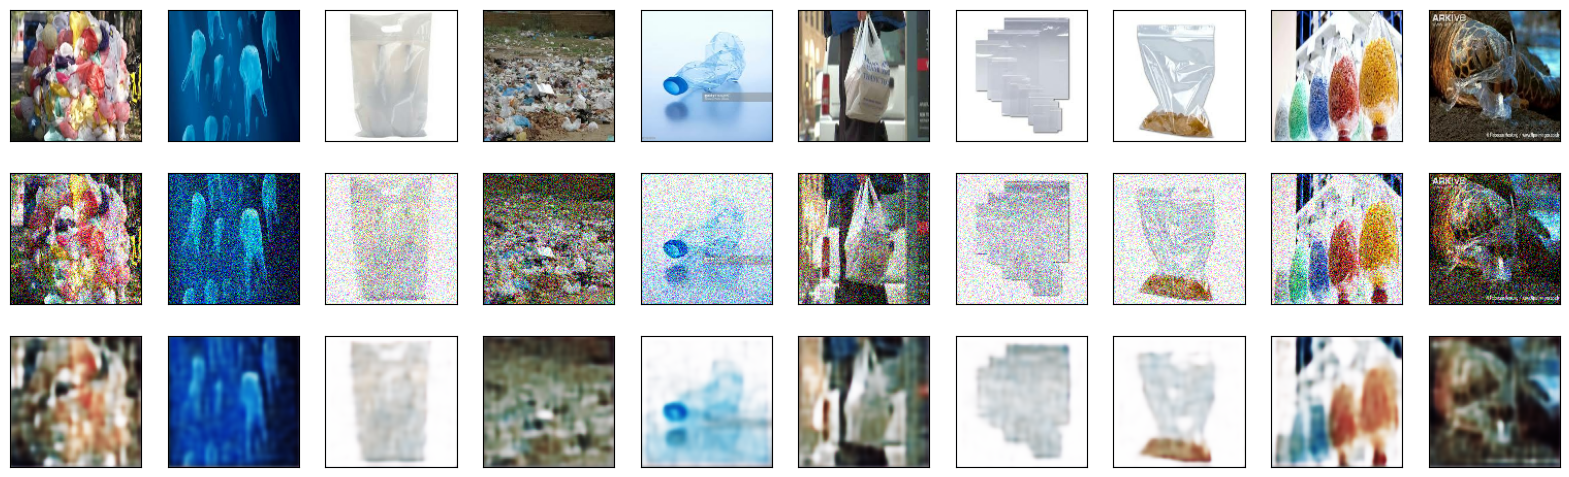

In [113]:
import matplotlib.pyplot as plt

# Predict the denoised images
# denoised_images = diffusion_model.predict(x_test_noisy)
denoised_images = new_model.predict(x_test_noisy)


# Visuzlise the results
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original 
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].clip(0,1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Displat noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].clip(0,1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_images[i].clip(0,1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)



### Autoencoders vs Diffusion models

Autoencoder: compress → reconstruct (reconstruction model).

Diffusion model: noise → denoise step by step (generative model).

They are not the same, but diffusion borrows ideas from denoising autoencoders. In fact, you can think of diffusion as a “very powerful denoising autoencoder unrolled over time.”